## **Exploratory Data Analysis**

References
- https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

Our dataset combines **IMDb movie details** and **user reviews**, sourced from the publicly available IMDb Spoiler Dataset on Kaggle.  
It contains:

- **~1.5k movies** with metadata such as title, genre, rating, and release date  
- **~570k reviews** written by IMDb users  
- Each review is labeled as either **spoiler** or **non-spoiler**

Every review also includes:
- The full **review text** and a short **summary/title**
- The reviewer’s unique **user ID**
- The **IMDb rating** they gave (1–10)
- The corresponding **movie ID**

The goal of this analysis is to understand **how spoiler and non-spoiler reviews differ** in tone, length, style, and context.  
These insights will guide our feature selection and preprocessing decisions for the spoiler-detection model.

We begin by exploring the **original raw data** to understand its structure, distribution, and potential biases.

### **With original data**

In [2]:
import kagglehub

path = kagglehub.dataset_download("rmisra/imdb-spoiler-dataset")
# print("Path to dataset files:", path)

In [3]:
import pandas as pd

movie_details = pd.read_json(path + "/IMDB_movie_details.json", lines=True)
reviews = pd.read_json(path + "/IMDB_reviews.json", lines=True)

In [4]:
print(reviews.info())
print(movie_details.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573913 entries, 0 to 573912
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   review_date     573913 non-null  object
 1   movie_id        573913 non-null  object
 2   user_id         573913 non-null  object
 3   is_spoiler      573913 non-null  bool  
 4   review_text     573913 non-null  object
 5   rating          573913 non-null  int64 
 6   review_summary  573913 non-null  object
dtypes: bool(1), int64(1), object(5)
memory usage: 26.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       1572 non-null   object 
 1   plot_summary   1572 non-null   object 
 2   duration       1572 non-null   object 
 3   genre          1572 non-null   object 
 4   rating         1572 non-null   float64
 5   r

In [5]:
print("\nMissing values (%):")
print((reviews.isna().mean() * 100).round(2))


Missing values (%):
review_date       0.0
movie_id          0.0
user_id           0.0
is_spoiler        0.0
review_text       0.0
rating            0.0
review_summary    0.0
dtype: float64


In [6]:
reviews.head()

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted"


In [7]:
len(reviews)

573913

In [8]:
movie_details.head()

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",1h 57min,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in..."
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",1h 45min,[Comedy],6.6,2013-11-01,Four boys around the age of 10 are friends in ...
2,tt0243655,"The setting is Camp Firewood, the year 1981. I...",1h 37min,"[Comedy, Romance]",6.7,2002-04-11,
3,tt0040897,"Fred C. Dobbs and Bob Curtin, both down on the...",2h 6min,"[Adventure, Drama, Western]",8.3,1948-01-24,Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...
4,tt0126886,Tracy Flick is running unopposed for this year...,1h 43min,"[Comedy, Drama, Romance]",7.3,1999-05-07,Jim McAllister (Matthew Broderick) is a much-a...


In [9]:
# number of unique movies in the dataset
num_unique_movies = movie_details['movie_id'].nunique()
print(f"Number of unique movies in the dataset: {num_unique_movies}")

Number of unique movies in the dataset: 1572


In [10]:
#checking for duplicate values
dups = reviews.duplicated(subset=['user_id', 'movie_id']).sum()
print(f"Duplicate (user_id, movie_id) pairs: {dups}")
print(f"Unique users: {reviews['user_id'].nunique()}, unique movies: {reviews['movie_id'].nunique()}")

Duplicate (user_id, movie_id) pairs: 0
Unique users: 263407, unique movies: 1572


#### **Spoiler vs Non-spoiler percentage**

This plot shows how balanced our dataset is between spoiler and non-spoiler reviews.
It also gives us a first feel for how often IMDb reviewers actually reveal spoilers.

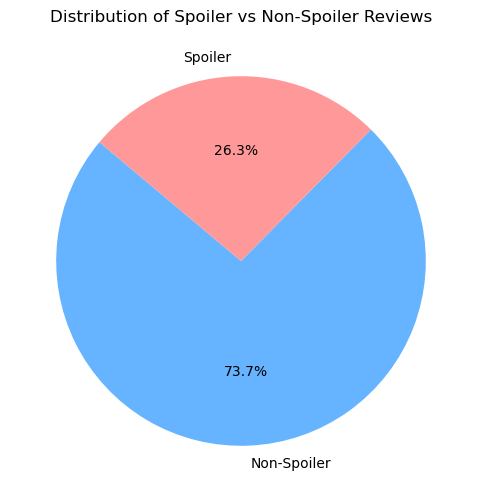

In [11]:
# spoiler distribution as pie chart
import matplotlib.pyplot as plt
spoiler_counts = reviews['is_spoiler'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(spoiler_counts, labels=['Non-Spoiler', 'Spoiler'], autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#ff9999'])
plt.title('Distribution of Spoiler vs Non-Spoiler Reviews')
plt.show()

From this plot, we can see that our dataset is not balanced- with over 73% reviews not containing spoilers. 

#### **Character/word Length Distribution of Reviews**

Here we compare how long spoiler and non-spoiler reviews tend to be.
Spoiler reviews are usually longer, since users often describe key scenes or endings — while non-spoiler reviews stay brief and opinion-focused.

<Axes: >

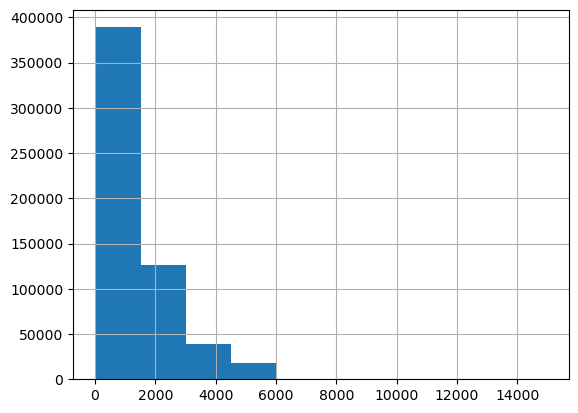

In [12]:
# review text char length distribution
reviews["review_text"].str.len().hist()

/var/folders/40/y23pyn757t7_mmd6zxqx59240000gn/T/ipykernel_45936/2572054195.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="is_spoiler", y="word_count", data=reviews, palette=['#66b3ff','#ff9999'], showfliers=False)


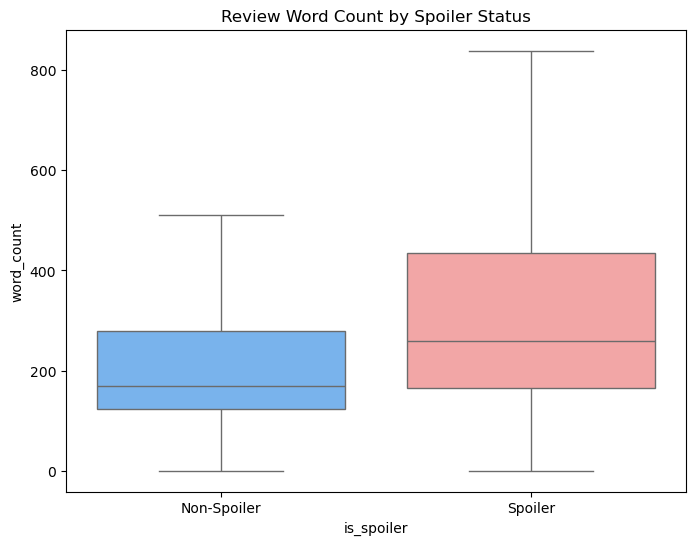

In [13]:
# review text word count box plot by spoiler status

reviews["word_count"] = reviews["review_text"].str.split().apply(len)
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.boxplot(x="is_spoiler", y="word_count", data=reviews, palette=['#66b3ff','#ff9999'], showfliers=False)
plt.xticks([0, 1], ['Non-Spoiler', 'Spoiler'])
plt.title('Review Word Count by Spoiler Status')
# plt.yscale('log')
plt.show()

#### **Number of exclamation marks in reviews (spoiler vs non-spoiler)**

This fun little metric captures writing “emotion.” 
We check if spoiler reviews have more exclamation marks a possible sign of excitement, surprise, or strong emotional reactions after plot reveals.

In [14]:
reviews["num_exclamation_marks"] = reviews["review_text"].str.count("!")
reviews[["num_exclamation_marks", "is_spoiler"]].groupby("is_spoiler").mean()

,num_exclamation_marks
is_spoiler,
False,0.841859
True,1.100991


#### **User based analysis**

Some reviewers contribute hundreds of reviews, while others write just one.
Understanding how these “power users” behave helps spot bias, for example, a few users might dominate spoiler content.

- We also found an interesting user- ur4248714: has crazy high spoiler reviews (1019 out of 1021 are spoilers)

In [15]:
# num of unique users
num_unique_users = reviews['user_id'].nunique()
print(f"Number of unique users in the dataset: {num_unique_users}")

Number of unique users in the dataset: 263407


In [16]:
# average number of reviews per user
average_reviews_per_user = len(reviews) / num_unique_users
print(f"Average number of reviews per user: {average_reviews_per_user}")

# most spoiling users
most_spoiling_users = reviews[reviews['is_spoiler'] == 1]['user_id'].value_counts().head(10)
print("Top 10 users with most spoiler reviews:")
print(most_spoiling_users)


Average number of reviews per user: 2.1788069413493187
Top 10 users with most spoiler reviews:
user_id
ur4248714     1019
ur60028700     767
ur5291991      540
ur7813355      503
ur22668817     473
ur2079400      454
ur2707735      441
ur45215448     422
ur13977076     417
ur1697212      415
Name: count, dtype: int64


In [17]:
# most reviews
most_reviews = reviews['user_id'].value_counts().head(10)
print("Top 10 users with most reviews:")
print(most_reviews)

Top 10 users with most reviews:
user_id
ur2898520     1303
ur4248714     1021
ur0453068      806
ur60028700     770
ur20552756     755
ur4888011      701
ur2488512      681
ur1234929      680
ur1293485      660
ur0482513      641
Name: count, dtype: int64


##### ur4248714: who are you?

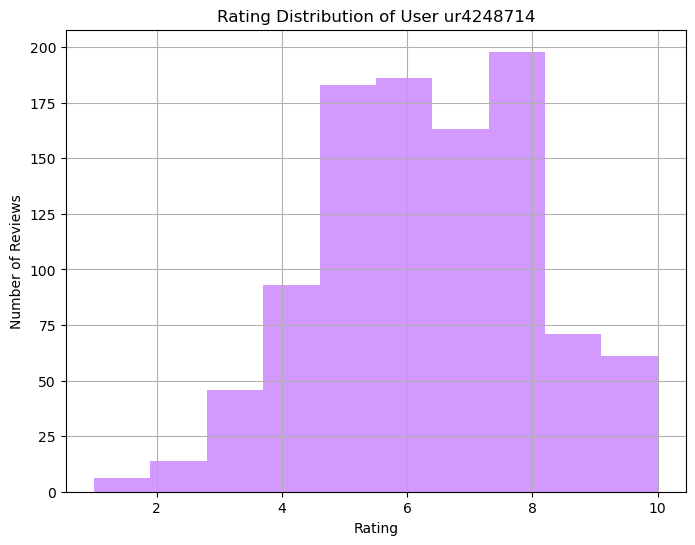

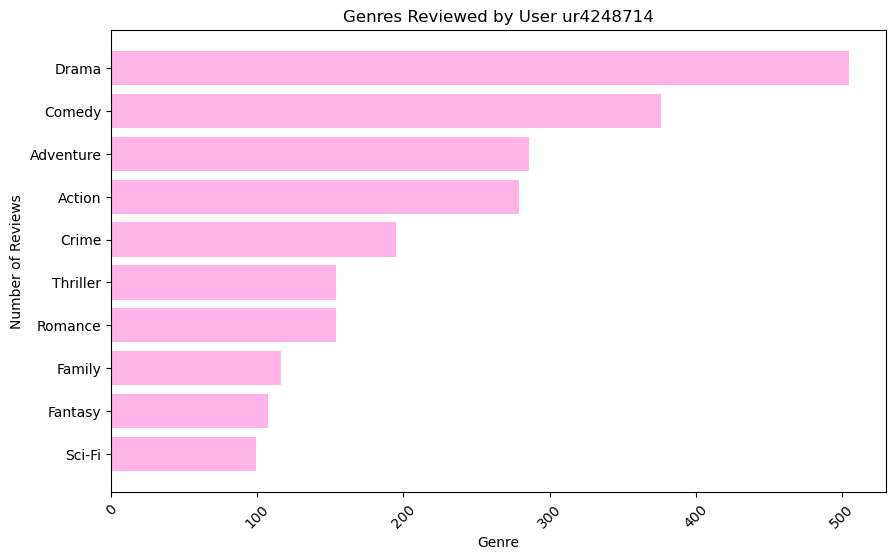

In [18]:
# ur4248714: who are you?

reviews[reviews['user_id'] == 'ur4248714']["rating"].value_counts()

# histogram of ur4248714 ratings
plt.figure(figsize=(8, 6))
reviews[reviews['user_id'] == 'ur4248714']["rating"].hist(bins=10, color="#d399ff")
plt.title('Rating Distribution of User ur4248714')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.show()

# bar plot of genres that ur4248714 reviews most
ur4248714_movie_ids = reviews[reviews['user_id'] == 'ur4248714']['movie_id'].unique()
ur4248714_movies = movie_details[movie_details['movie_id'].isin(ur4248714_movie_ids)]
ur4248714_genres = ur4248714_movies['genre'].explode()
ur4248714_genre_counts = ur4248714_genres.value_counts()[:10][::-1]
plt.figure(figsize=(10, 6))
plt.barh(ur4248714_genre_counts.index, ur4248714_genre_counts.values, color="#ffb3e6")
plt.xticks(rotation=45)
plt.title('Genres Reviewed by User ur4248714')
plt.xlabel('Genre')
plt.ylabel('Number of Reviews')
plt.show()

#### **Rating vs Spoiler Status**

Spoiler reviews tend to be for lower rated movies than non-spoiler reviews (ig if you don't like a movie, you're more likely to spoil it for others)

In [19]:
# average rating by spoiler status
reviews[["rating", "is_spoiler"]].groupby("is_spoiler").mean()

,rating
is_spoiler,
False,7.110031
True,6.517665


/var/folders/40/y23pyn757t7_mmd6zxqx59240000gn/T/ipykernel_45936/277262877.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="is_spoiler", y="rating", data=reviews, palette=['#66b3ff','#ff9999'])


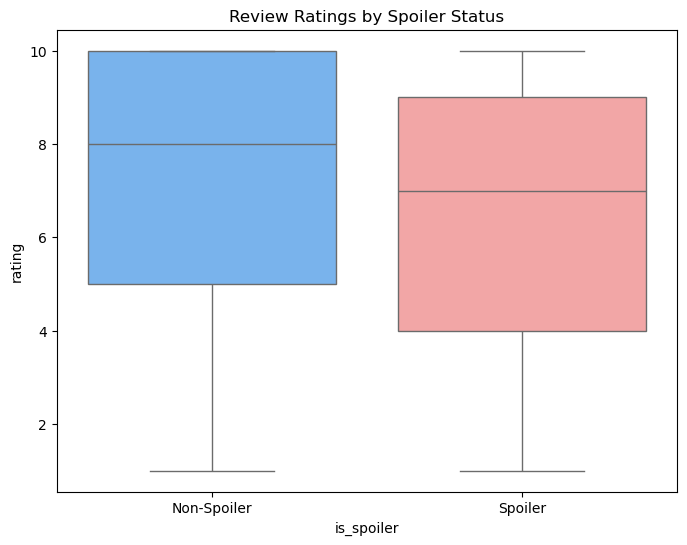

In [20]:
# box plot of ratings by spoiler status
plt.figure(figsize=(8, 6))
sns.boxplot(x="is_spoiler", y="rating", data=reviews, palette=['#66b3ff','#ff9999'])
plt.xticks([0, 1], ['Non-Spoiler', 'Spoiler'])
plt.title('Review Ratings by Spoiler Status')
plt.show()

#### **Genres with most spoilers**

Different genres invite different reviewing styles.
Thrillers, mysteries, or dramas often have more spoilers because talking about them means revealing key story points.

In [21]:
# genres with most spoilers (percentage)
# genre is a column with list of genres, need to explode it first
merged = reviews.merge(movie_details[['movie_id', 'genre']], on='movie_id', how='left')
merged = merged.explode('genre')
genre_spoiler_counts = merged.groupby('genre')['is_spoiler'].agg(['sum', 'count'])
genre_spoiler_counts['spoiler_percentage'] = (genre_spoiler_counts['sum'] / genre_spoiler_counts['count']) * 100
top_genres_spoilers = genre_spoiler_counts.sort_values(by='spoiler_percentage', ascending=False).head(10)
print("Top 10 genres with highest spoiler percentage:")
print(top_genres_spoilers[['spoiler_percentage']])

print("Bottom 10 genres with lowest spoiler percentage:")
print(genre_spoiler_counts.sort_values(by='spoiler_percentage', ascending=True).head(10))

Top 10 genres with highest spoiler percentage:
           spoiler_percentage
genre                        
Sci-Fi              31.211931
Horror              29.666125
Mystery             28.947245
Adventure           28.689807
Action              28.260197
Fantasy             28.138214
Thriller            28.114597
Film-Noir           27.247348
Family              27.053262
Animation           25.694627
Bottom 10 genres with lowest spoiler percentage:
             sum   count  spoiler_percentage
genre                                       
Musical     1120    5518           20.297209
Music       1838    8756           20.991320
Comedy     29315  135968           21.560220
History     5668   24039           23.578352
Romance    16155   68301           23.652655
Sport       2012    8384           23.998092
Biography   7992   33107           24.139910
War         2486   10228           24.305827
Crime      27011  109670           24.629343
Western     1209    4741           25.500949


#### **Average Movie Length Per Genre**

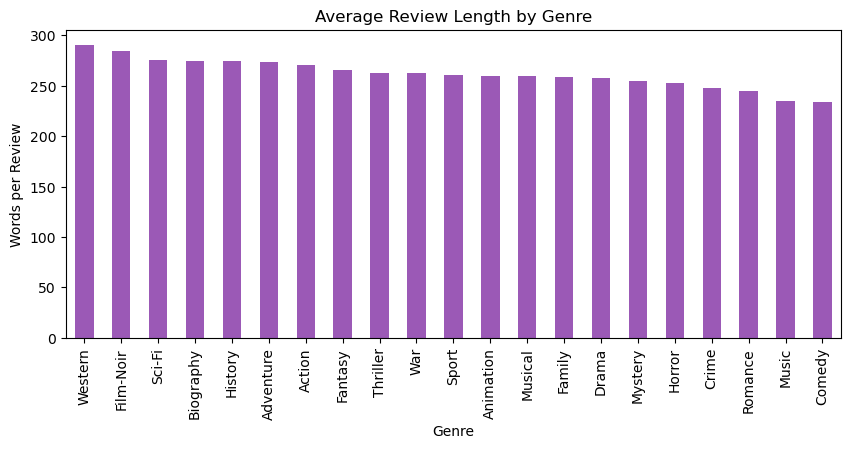

In [22]:
# merge reviews with movie_details to bring in genres
merged = reviews.merge(movie_details[['movie_id', 'genre']], on='movie_id', how='left')

# compute average review length per genre
merged['length'] = merged['review_text'].str.split().str.len()

genre_lengths = (
    merged.explode('genre')
    .groupby('genre')['length']
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10,4))
genre_lengths.plot(kind='bar', color='#9b59b6')
plt.title("Average Review Length by Genre")
plt.ylabel("Words per Review")
plt.xlabel("Genre")
plt.show()


#### **Most reviewed genres**

This chart shows which genres are the most popular overall on IMDb (in review counts).
It helps us see whether the spoiler trends above are just due to popularity or if certain genres genuinely attract more spoiler-heavy reviews.

In [23]:
# most reviewed genres
most_reviewed_genres = merged['genre'].value_counts().head(10)
print("Top 10 most reviewed genres:")
print(most_reviewed_genres)

Top 10 most reviewed genres:
genre
[Action, Adventure, Sci-Fi]     39842
[Action, Adventure, Fantasy]    22658
[Crime, Drama]                  19258
[Drama]                         17976
[Drama, Romance]                16418
[Comedy, Drama, Romance]        14935
[Crime, Drama, Thriller]        14573
[Action, Crime, Drama]          13602
[Crime, Drama, Mystery]         13578
[Comedy]                        12835
Name: count, dtype: int64


#### **Most reviewed movies**

- The Dark Knight (2008) has been reviewed 4845 times with 30.59% spoilers

In [24]:
# most reviewed movies with spoiler percentage
most_reviewed_movies = reviews['movie_id'].value_counts().head(10)

# Get spoiler percentages for the most reviewed movies
for movie_id in most_reviewed_movies.index:
    vc = reviews[reviews['movie_id'] == movie_id]["is_spoiler"].value_counts()
    spoiler_percentage = (vc.get(1, 0) / vc.sum()) * 100
    print(f"Movie: {movie_id}, Reviews: {most_reviewed_movies[movie_id]} ({spoiler_percentage:.2f}%)")

Movie: tt0468569, Reviews: 4845 (30.59%)
Movie: tt0111161, Reviews: 4361 (21.92%)
Movie: tt0167260, Reviews: 2729 (17.96%)
Movie: tt0137523, Reviews: 2480 (18.51%)
Movie: tt0068646, Reviews: 2137 (19.65%)
Movie: tt0110912, Reviews: 1994 (19.91%)
Movie: tt0108052, Reviews: 1151 (21.55%)
Movie: tt0050083, Reviews: 916 (27.18%)
Movie: tt0974015, Reviews: 751 (37.02%)
Movie: tt5109784, Reviews: 751 (28.36%)


/var/folders/40/y23pyn757t7_mmd6zxqx59240000gn/T/ipykernel_45936/840531533.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spoiler_percentage = (vc.get(1, 0) / vc.sum()) * 100


In [25]:
vc = reviews[reviews['movie_id'] == "tt0468569"]["is_spoiler"].value_counts()
print(vc)
#percentage of spoiler reviews for The Dark Knight
spoiler_percentage_dark_knight = (vc.iloc[1] / vc.sum()) * 100
print(f"Percentage of spoiler reviews for The Dark Knight: {spoiler_percentage_dark_knight:.2f}%")

is_spoiler
False    3363
True     1482
Name: count, dtype: int64
Percentage of spoiler reviews for The Dark Knight: 30.59%


#### **Most spoiled movies (by spoiler percentage)**

- Star Wars: Episode VII - The Force Awakens (2015) has the highest spoiler percentage of 65.22% among movies

In [26]:
# most spoiled movies

# merged = reviews.merge(movie_details[['movie_id']], on='movie_id', how='left')
movie_spoiler_counts = merged.groupby(['movie_id'])['is_spoiler'].agg(['sum', 'count'])
movie_spoiler_counts['spoiler_percentage'] = (movie_spoiler_counts['sum'] / movie_spoiler_counts['count']) * 100
most_spoiled_movies = movie_spoiler_counts.sort_values(by='spoiler_percentage', ascending=False).head(10)
print("Top 10 most spoiled movies:")
print(most_spoiled_movies)

Top 10 most spoiled movies:
           sum  count  spoiler_percentage
movie_id                                 
tt2488496  482    739           65.223275
tt0118928  123    222           55.405405
tt1300854  390    719           54.242003
tt1446714  400    739           54.127199
tt1037705  283    552           51.268116
tt0814255  203    399           50.877193
tt1197624  211    415           50.843373
tt0201265    2      4           50.000000
tt1074638  366    734           49.863760
tt0376994  364    732           49.726776


#### **Highest rated movie**

- Brokeback Mountain (2005) has the highest average rating of 9.8 with 21.12% spoilers

In [27]:
# highest rated movie with spoiler percentage
movie_ratings = reviews.groupby('movie_id')['rating'].mean()
highest_rated_movie = movie_ratings.sort_values(ascending=False).head(10)

# Get spoiler percentages for the highest rated movies
for movie_id in highest_rated_movie.index:
    vc = reviews[reviews['movie_id'] == movie_id]["is_spoiler"].value_counts()
    spoiler_percentage = (vc.get(1, 0) / vc.sum()) * 100
    print(f"Movie: {movie_id}, Rating: {highest_rated_movie[movie_id]:.2f}, Spoiler Percentage: {spoiler_percentage:.2f}% ({vc.get(1, 0)} spoilers out of {vc.sum()} reviews)")

Movie: tt0388795, Rating: 9.80, Spoiler Percentage: 21.12% (155 spoilers out of 734 reviews)
Movie: tt0080684, Rating: 9.50, Spoiler Percentage: 23.69% (95 spoilers out of 401 reviews)
Movie: tt0054215, Rating: 9.40, Spoiler Percentage: 32.36% (133 spoilers out of 411 reviews)
Movie: tt0103064, Rating: 9.39, Spoiler Percentage: 19.52% (122 spoilers out of 625 reviews)
Movie: tt0088763, Rating: 9.39, Spoiler Percentage: 23.49% (109 spoilers out of 464 reviews)
Movie: tt0111161, Rating: 9.30, Spoiler Percentage: 21.92% (956 spoilers out of 4361 reviews)
Movie: tt0986264, Rating: 9.25, Spoiler Percentage: 14.77% (44 spoilers out of 298 reviews)
Movie: tt0036868, Rating: 9.23, Spoiler Percentage: 14.29% (28 spoilers out of 196 reviews)
Movie: tt0060196, Rating: 9.20, Spoiler Percentage: 22.27% (161 spoilers out of 723 reviews)
Movie: tt0082096, Rating: 9.20, Spoiler Percentage: 15.64% (56 spoilers out of 358 reviews)


/var/folders/40/y23pyn757t7_mmd6zxqx59240000gn/T/ipykernel_45936/2844525663.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spoiler_percentage = (vc.get(1, 0) / vc.sum()) * 100
/var/folders/40/y23pyn757t7_mmd6zxqx59240000gn/T/ipykernel_45936/2844525663.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Movie: {movie_id}, Rating: {highest_rated_movie[movie_id]:.2f}, Spoiler Percentage: {spoiler_percentage:.2f}% ({vc.get(1, 0)} spoilers out of {vc.sum()} reviews)")


### **With preprocessed data**
(processed in 02_preprocessing.ipynb)

In [28]:
import pandas as pd

movie_details_pp = pd.read_feather("../data/preprocessed_movie_details.feather")
reviews_pp = pd.read_feather("../data/preprocessed_reviews.feather")

In [29]:
movie_details_pp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   movie_id                1572 non-null   object 
 1   plot_summary            1572 non-null   object 
 2   duration                1572 non-null   object 
 3   genre                   1572 non-null   object 
 4   rating                  1572 non-null   float64
 5   release_date            1572 non-null   object 
 6   plot_synopsis           1572 non-null   object 
 7   original_plot_summary   1572 non-null   object 
 8   original_plot_synopsis  1572 non-null   object 
dtypes: float64(1), object(8)
memory usage: 110.7+ KB


In [30]:
reviews_pp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573913 entries, 0 to 573912
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   review_date              573913 non-null  object
 1   movie_id                 573913 non-null  object
 2   user_id                  573913 non-null  object
 3   is_spoiler               573913 non-null  bool  
 4   review_text              573913 non-null  object
 5   rating                   573913 non-null  int64 
 6   review_summary           573913 non-null  object
 7   original_review_text     573913 non-null  object
 8   original_review_summary  573913 non-null  object
 9   review_text_ner          573913 non-null  object
 10  review_summary_ner       573913 non-null  object
dtypes: bool(1), int64(1), object(9)
memory usage: 44.3+ MB


In [31]:
movie_details_pp.sample(10, random_state=234)

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis,original_plot_summary,original_plot_synopsis
27,tt0108399,"[detroit, clarence, worley, go, movie, theater...",2h,"[Crime, Drama, Romance]",7.9,1993-09-10,"[comic, book, store, clerk, film, buff, claren...","In Detroit, Clarence Worley goes to the movie ...",Comic book store clerk and film buff Clarence ...
227,tt0482606,"[return, wed, reception, couple, stay, isolate...",1h 26min,"[Horror, Mystery, Thriller]",6.2,2008-05-30,"[kristen, mckay, liv, tyler, james, hoyt, scot...","After returning from a wedding reception, a co...",Kristen McKay (Liv Tyler) and James Hoyt (Scot...
343,tt0186151,"[rare, atmospheric, phenomenon, allow, new, yo...",1h 58min,"[Crime, Drama, Mystery]",7.4,2000-04-28,"[october, frank, sullivan, new, york, city, fi...",A rare atmospheric phenomenon allows a New Yor...,It is October 1969. Frank Sullivan is a New Yo...
981,tt2293640,"[ever, since, dawn, time, minion, live, serve,...",1h 31min,"[Animation, Action, Adventure]",6.4,2015-07-10,"[movie, start, narration, minion, exist, since...","Ever since the dawn of time, the Minions have ...",The movie starts with a narration about the mi...
505,tt1078940,"[dave, ronnie, jason, cynthia, joey, lucy, clo...",1h 53min,[Comedy],5.5,2009-10-09,"[movie, focus, couple, marry, two, young, kid,...","Dave and Ronnie, Jason and Cynthia, and Joey a...",This movie focuses on 4 couples: * The married...
326,tt5715874,"[untimely, death, year, old, martin, father, o...",2h 1min,"[Drama, Horror, Mystery]",7.3,2017-11-03,[],After the untimely death of 16-year-old Martin...,
1280,tt0468569,"[set, within, year, event, batman, begin, batm...",2h 32min,"[Action, Crime, Drama]",9.0,2008-07-18,"[movie, begin, gang, men, clown, mask, break, ...",Set within a year after the events of Batman B...,The movie begins with a gang of men with clown...
502,tt0151738,"[chicago, sun, time, copy, editor, josie, gell...",1h 47min,"[Comedy, Drama, Romance]",6.0,1999-04-09,"[josie, geller, draw, barrymore, highly, intel...",Chicago Sun Times copy editor Josie Gellar (25...,Josie Geller (Drew Barrymore) is a highly inte...
1166,tt0101587,"[mitch, middle, age, big, city, radio, ad, sal...",1h 53min,[Comedy],6.7,1991-06-07,"[mitch, robbins, billy, crystal, best, friend,...",Mitch is a middle aged big-city radio ads sale...,Mitch Robbins (Billy Crystal) and his best fri...
585,tt0455944,"[equalizer, denzel, washington, play, mccall, ...",2h 12min,"[Action, Crime, Thriller]",7.2,2014-09-26,"[robert, mccall, denzel, washington, get, earl...","In The Equalizer, Denzel Washington plays McCa...",Robert McCall (Denzel Washington) gets up earl...


In [32]:
reviews_pp["review_text"].sample(10, random_state=134).tolist()

[array(['doubt', 'big', 'budget', 'box', 'office', 'hit', 'hype',
        'surround', 'movie', 'feel', 'score', 'base', 'rather', 'quality',
        'film', 'make', 'script', 'act', 'let', 'explain', 'christian',
        'bale', 'delivers', 'solid', 'batman', 'performance', 'raspy',
        'batman', 'voice', 'get', 'laughable', 'time', 'one', 'cant',
        'help', 'think', 'may', 'blow', 'ring', 'try', 'add', 'nut',
        'voice', 'support', 'cast', 'freeman', 'etc', 'around', 'decent',
        'definitely', 'lose', 'point', 'book', 'drop', 'lead', 'actress',
        'first', 'film', 'perhaps', 'kate', 'holmes', 'go', 'scientology',
        'boot', 'camp', 'gary', 'oldman', 'real', 'treat', 'watch', 'act',
        'always', 'pleasure', 'excite', 'landed', 'role', 'gordon', 'keep',
        'definitely', 'one', 'best', 'actor', 'time', 'finally', 'joker',
        'get', 'wrong', 'mr', 'ledger', 'fair', 'job', 'play', 'joker',
        'performance', 'seem', 'base', 'nicholson', 'joke

#### **Word Cloud of Most Common Words in Reviews (grouped by spoiler/non-spoiler)**

Total length of all reviews text: 503601764 characters


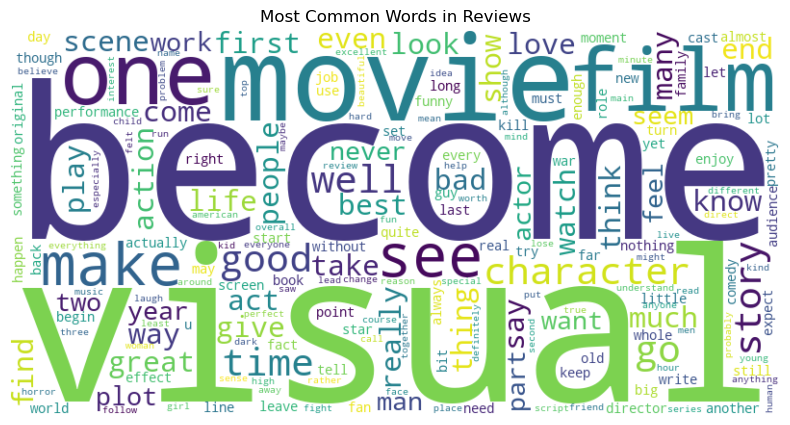

In [33]:
# wordcloud of most common words in reviews
from collections import Counter
from wordcloud import WordCloud
from matplotlib import pyplot as plt

all_reviews_text = reviews_pp["review_text"].explode().str.cat(sep=' ')
print(f"Total length of all reviews text: {len(all_reviews_text)} characters")

# keep only top 1000 words for wordcloud

word_freq = Counter(all_reviews_text.split())
top_words = dict(word_freq.most_common(1000))
all_reviews_text = ' '.join(top_words.keys())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Reviews')
plt.show()


Total length of spoiler reviews text: 170697258 characters


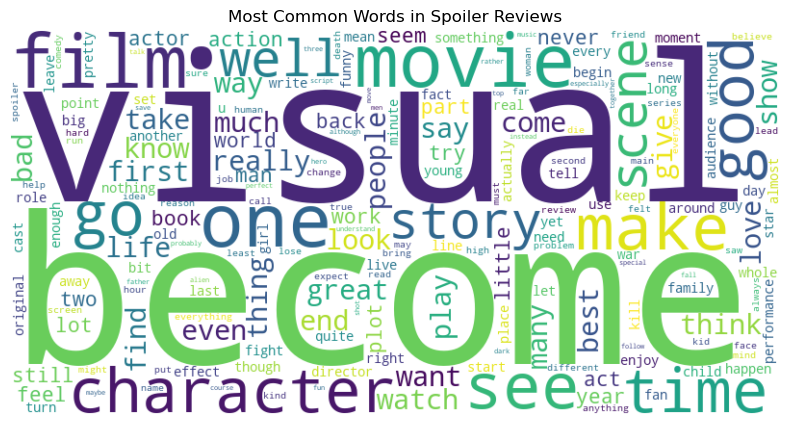

In [34]:
# most common words in spoiler reviews
spoiler_reviews_text = reviews_pp[reviews_pp["is_spoiler"] == 1]["review_text"].explode().str.cat(sep=' ')
print(f"Total length of spoiler reviews text: {len(spoiler_reviews_text)} characters")

# keep only top 1000 words for wordcloud

word_freq = Counter(spoiler_reviews_text.split())
top_words = dict(word_freq.most_common(1000))
spoiler_reviews_text = ' '.join(top_words.keys())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spoiler_reviews_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Spoiler Reviews')
plt.show()


Total length of non-spoiler reviews text: 332904505 characters


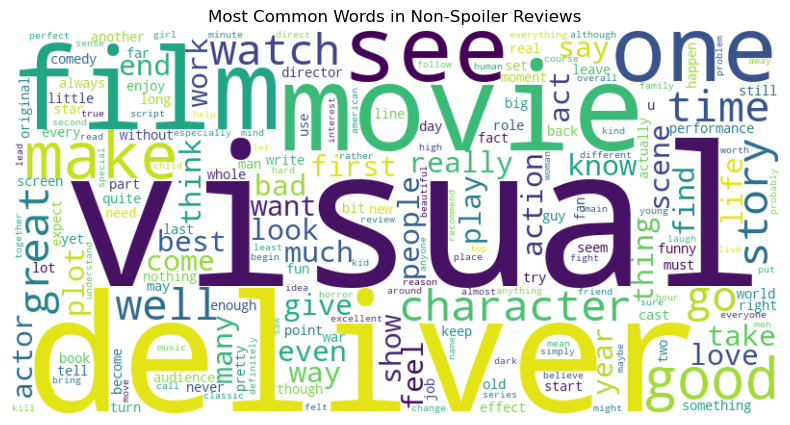

In [35]:
# most common words in non-spoiler reviews
non_spoiler_reviews_text = reviews_pp[reviews_pp["is_spoiler"] == 0]["review_text"].explode().str.cat(sep=' ')
print(f"Total length of non-spoiler reviews text: {len(non_spoiler_reviews_text)} characters")  

# keep only top 1000 words for wordcloud

word_freq = Counter(non_spoiler_reviews_text.split())
top_words = dict(word_freq.most_common(1000))
non_spoiler_reviews_text = ' '.join(top_words.keys())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(non_spoiler_reviews_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Non-Spoiler Reviews')
plt.show()


#### **Frequent Words by Class**
We compare the most common tokens used in spoiler vs non-spoiler reviews. This highlights which kinds of words appear more often in each type of review.


In [36]:
from collections import Counter
from itertools import chain
import numpy as np

def top_words(series, n=10):
    # flatten if elements are lists/arrays instead of strings
    if isinstance(series.iloc[0], (list, np.ndarray)):
        words = list(chain.from_iterable(series))
    else:
        words = " ".join(series.astype(str)).split()
    return pd.Series(Counter(words)).nlargest(n)

spoiler_top = top_words(reviews_pp[reviews_pp['is_spoiler']==True]['review_text'])
non_top = top_words(reviews_pp[reviews_pp['is_spoiler']==False]['review_text'])

pd.DataFrame({'Spoiler': spoiler_top, 'Non-Spoiler': non_top})


,Spoiler,Non-Spoiler
character,163582.0,323968.0
film,379930.0,891510.0
get,159915.0,NaN
go,142420.0,NaN
good,145927.0,339703.0
like,200611.0,397130.0
make,188553.0,394553.0
movie,492625.0,1189554.0
one,219035.0,466409.0
see,171645.0,397497.0


#### **How often do reviewers mention "spoiler" in non-spoiler reviews vs spoiler reviews?**

Could be improved by looking for variations like "If you haven't seen the movie, don't read this review" etc.

In [37]:
# number of times "spoiler" appears in spoiler vs non-spoiler reviews

# review_text in reviews_pp may be lists (tokenized) or other non-string types.
# Convert each review to a plain string first, then use .str accessor.
from pandas.api.types import is_list_like

def _to_text(x):
	# treat list-like objects (including numpy arrays, pandas Series) but not strings
	if is_list_like(x) and not isinstance(x, (str, bytes)):
		return ' '.join(map(str, x))
	if pd.isna(x):
		return ''
	return str(x)

spoiler_texts = reviews_pp["review_text"].apply(_to_text).str.lower()
spoiler_count_spoiler_reviews = spoiler_texts[reviews_pp["is_spoiler"] == 1].str.count("spoiler").sum()
spoiler_count_non_spoiler_reviews = spoiler_texts[reviews_pp["is_spoiler"] == 0].str.count("spoiler").sum()
print(f'The word "spoiler" appears {spoiler_count_spoiler_reviews} out of {len(reviews_pp[reviews_pp["is_spoiler"] == 1])} ({spoiler_count_spoiler_reviews / len(reviews_pp[reviews_pp["is_spoiler"] == 1]) * 100:.2f}%) spoiler reviews.')
print(f'The word "spoiler" appears {spoiler_count_non_spoiler_reviews} out of {len(reviews_pp[reviews_pp["is_spoiler"] == 0])} ({spoiler_count_non_spoiler_reviews / len(reviews_pp[reviews_pp["is_spoiler"] == 0]) * 100:.2f}%) non-spoiler reviews.')

The word "spoiler" appears 23319 out of 150924 (15.45%) spoiler reviews.
The word "spoiler" appears 8346 out of 422989 (1.97%) non-spoiler reviews.


In [38]:
# sample reviews containing the word "spoiler"
reviews_with_spoiler = reviews_pp[spoiler_texts.str.contains("spoiler") & (reviews_pp["is_spoiler"] == 1)]
reviews_with_spoiler.sample(10, random_state=345)["original_review_text"].map(_to_text).tolist()

['***MILD SPOILER*** I had the chance to see the norwegian version of Insomnia a few years ago and I can\'t say I was impressed.  Being an insomniac myself I was intrigued to watch this film too especially when I found out that two of my favorite actors were in it (always cool Martin Donovan and Al the man Pacino).I never really understood what all the fuzz about Christopher Nolan is all about.  Following was clever but nothing to write home about and while the trick he used in Memento made the film really popular I thought the film was inferior to Gaspar Noe\'s "Irreversible".  What I think Christopher Nolan\'s films lack is a heart and a meaning and unfortunately Insomnia isn\'t an exception.The film has a lot of great actors, Pacino is good as usual and both Robin Williams and Hilary Swank play their parts well, but there\'s still something lacking. Martin Donovan died too soon (sorry for the spoiler) and I think Nolan focused too much on Pacino\'s guilts for what happened than on h

In [39]:
reviews_with_spoiler = reviews_pp[spoiler_texts.str.contains("spoiler") & (reviews_pp["is_spoiler"] == 0)]
reviews_with_spoiler.sample(10, random_state=345)["original_review_text"].map(_to_text).tolist()

["Rain splattering down all over, and blood giving it a close competition..... 10 ppl stuck in a dingy motel,one severely injured, one cop ,one convict and several shady characters included... and as expected suddenly a competition begins of who can get killed before whom and the countdown begins to give the gold medal to the struggling survivor....... But all of a sudden enters a mental patient,hence changing the entire ball game..... none the less, it's very entertaining.... and the twist in the tail,, really twists it painfully hard,, overall, nice thriller film...It did have it's funny moments though-- how can u kill someone by an overspeeding car when ur speedometer reads zero? How can a broken lock hold a door when 2 ppl were trying to choke-slam it, undertaker style?? there r many more, but i don't wanna give the spoilers here..So it's recommended to all those who liked films like-- shutter island, stay, Mulholland drive etc...",
 "This was a movie that had an intriguing story, 

#### **Count of Named Entities in spoiler vs non-spoiler reviews**

- Not much difference seen here. It's only slightly higher in spoiler reviews. (Expected spoiler reviews to have significantly higher named entity counts but no)

In [40]:
# calculate total number of named entities per review

def get_total_named_entities(ner_dict):
    return sum(count for count in ner_dict.values() if count is not None)

reviews_pp["num_named_entities"] = reviews_pp["review_text_ner"].apply(get_total_named_entities)
reviews_pp.sample(5, random_state=234)

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary,original_review_text,original_review_summary,review_text_ner,review_summary_ner,num_named_entities
244476,8 August 2016,tt1386697,ur68277297,False,"[know, wrong, critic, nowadays, jumpy, marvel,...",9,"[movie, amazing]",I don't know what's wrong with the critics now...,This movie is amazing.,"{'CARDINAL': None, 'DATE': None, 'EVENT': None...","{'CARDINAL': None, 'DATE': None, 'EVENT': None...",12.0
569344,30 June 2000,tt0120655,ur0781795,False,"[funny, movie, see, long, time, kevin, smith, ...",8,"[hilarious, movie, great, cast, great, plot]",This was the funniest movie I had seen in a lo...,A hilarious movie with a great cast and a grea...,"{'CARDINAL': None, 'DATE': None, 'EVENT': None...","{'CARDINAL': None, 'DATE': None, 'EVENT': None...",10.0
194640,28 September 2013,tt0816711,ur46940562,False,"[caught, dvd, zombie, run, like, gazelle, even...",9,"[new, breed, zombie]",I just caught this on DVD. Having the zombies ...,New Breed of Zombies,"{'CARDINAL': None, 'DATE': None, 'EVENT': None...","{'CARDINAL': None, 'DATE': None, 'EVENT': None...",2.0
393096,25 November 2005,tt0294870,ur2817149,True,"[far, movie, go, would, put, classification, b...",10,"[love, broadway, show, loved, movie, even]","As far as this movie goes, I would put it in t...",I loved the Broadway show... but I loved the m...,"{'CARDINAL': None, 'DATE': None, 'EVENT': None...","{'CARDINAL': None, 'DATE': None, 'EVENT': None...",9.0
365388,18 June 2005,tt0369339,ur5492998,True,"[tom, cruise, play, hit, man, name, vincent, d...",8,"[good, movie]",tom cruise plays a hit-man named Vincent who d...,a very good movie,"{'CARDINAL': None, 'DATE': None, 'EVENT': None...","{'CARDINAL': None, 'DATE': None, 'EVENT': None...",11.0


In [41]:
# Named entity count to token count ratio
reviews_pp["ner_to_token_count_ratio"] = reviews_pp["num_named_entities"] / reviews_pp["review_text"].apply(len)
reviews_pp.sample(5, random_state=234)

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary,original_review_text,original_review_summary,review_text_ner,review_summary_ner,num_named_entities,ner_to_token_count_ratio
244476,8 August 2016,tt1386697,ur68277297,False,"[know, wrong, critic, nowadays, jumpy, marvel,...",9,"[movie, amazing]",I don't know what's wrong with the critics now...,This movie is amazing.,"{'CARDINAL': None, 'DATE': None, 'EVENT': None...","{'CARDINAL': None, 'DATE': None, 'EVENT': None...",12.0,0.102564
569344,30 June 2000,tt0120655,ur0781795,False,"[funny, movie, see, long, time, kevin, smith, ...",8,"[hilarious, movie, great, cast, great, plot]",This was the funniest movie I had seen in a lo...,A hilarious movie with a great cast and a grea...,"{'CARDINAL': None, 'DATE': None, 'EVENT': None...","{'CARDINAL': None, 'DATE': None, 'EVENT': None...",10.0,0.196078
194640,28 September 2013,tt0816711,ur46940562,False,"[caught, dvd, zombie, run, like, gazelle, even...",9,"[new, breed, zombie]",I just caught this on DVD. Having the zombies ...,New Breed of Zombies,"{'CARDINAL': None, 'DATE': None, 'EVENT': None...","{'CARDINAL': None, 'DATE': None, 'EVENT': None...",2.0,0.039216
393096,25 November 2005,tt0294870,ur2817149,True,"[far, movie, go, would, put, classification, b...",10,"[love, broadway, show, loved, movie, even]","As far as this movie goes, I would put it in t...",I loved the Broadway show... but I loved the m...,"{'CARDINAL': None, 'DATE': None, 'EVENT': None...","{'CARDINAL': None, 'DATE': None, 'EVENT': None...",9.0,0.051136
365388,18 June 2005,tt0369339,ur5492998,True,"[tom, cruise, play, hit, man, name, vincent, d...",8,"[good, movie]",tom cruise plays a hit-man named Vincent who d...,a very good movie,"{'CARDINAL': None, 'DATE': None, 'EVENT': None...","{'CARDINAL': None, 'DATE': None, 'EVENT': None...",11.0,0.142857


In [42]:
# average number of named entities in spoiler vs non-spoiler reviews
avg_named_entities_spoiler = reviews_pp[reviews_pp["is_spoiler"] == 1]["num_named_entities"].mean()
avg_named_entities_non_spoiler = reviews_pp[reviews_pp["is_spoiler"] == 0]["num_named_entities"].mean()
print(f"Average number of named entities in spoiler reviews: {avg_named_entities_spoiler:.2f}")
print(f"Average number of named entities in non-spoiler reviews: {avg_named_entities_non_spoiler:.2f}")

Average number of named entities in spoiler reviews: 18.12
Average number of named entities in non-spoiler reviews: 12.09


In [43]:
# average named entity to token count ratio in spoiler vs non-spoiler reviews
avg_ner_to_token_ratio_spoiler = reviews_pp[reviews_pp["is_spoiler"] == 1]["ner_to_token_count_ratio"].mean()
avg_ner_to_token_ratio_non_spoiler = reviews_pp[reviews_pp["is_spoiler"] == 0]["ner_to_token_count_ratio"].mean()
print(f"Average named entity to token count ratio in spoiler reviews: {avg_ner_to_token_ratio_spoiler:.4f}")
print(f"Average named entity to token count ratio in non-spoiler reviews: {avg_ner_to_token_ratio_non_spoiler:.4f}")

Average named entity to token count ratio in spoiler reviews: 0.1003
Average named entity to token count ratio in non-spoiler reviews: 0.0957


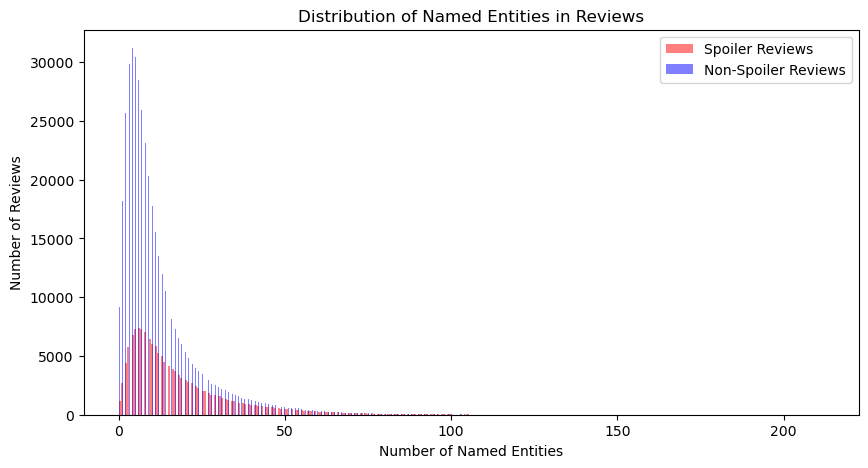

In [44]:
# histogram of number of named entities in spoiler vs non-spoiler reviews
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(reviews_pp[reviews_pp["is_spoiler"] == 1]["num_named_entities"], bins='auto', alpha=0.5, label='Spoiler Reviews', color='red')
plt.hist(reviews_pp[reviews_pp["is_spoiler"] == 0]["num_named_entities"], bins='auto', alpha=0.5, label='Non-Spoiler Reviews', color='blue')
plt.xlabel('Number of Named Entities')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Named Entities in Reviews')
plt.legend()

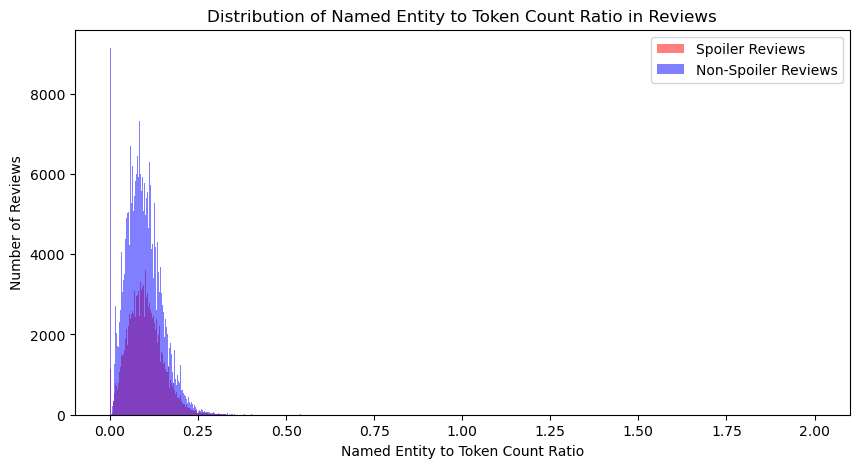

In [45]:
# histogram of named entity to token count ratio in spoiler vs non-spoiler reviews
plt.figure(figsize=(10, 5))
plt.hist(reviews_pp[reviews_pp["is_spoiler"] == 1]["ner_to_token_count_ratio"], bins='auto', alpha=0.5, label='Spoiler Reviews', color='red')
plt.hist(reviews_pp[reviews_pp["is_spoiler"] == 0]["ner_to_token_count_ratio"], bins='auto', alpha=0.5, label='Non-Spoiler Reviews', color='blue')
plt.xlabel('Named Entity to Token Count Ratio')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Named Entity to Token Count Ratio in Reviews')
plt.legend()

## BERT Tokens

Token indices sequence length is longer than the specified maximum sequence length for this model (1143 > 512). Running this sequence through the model will result in indexing errors


Token length percentiles (50/75/90/95/99/max): [ 241.  411.  679.  887. 1220.] 3319


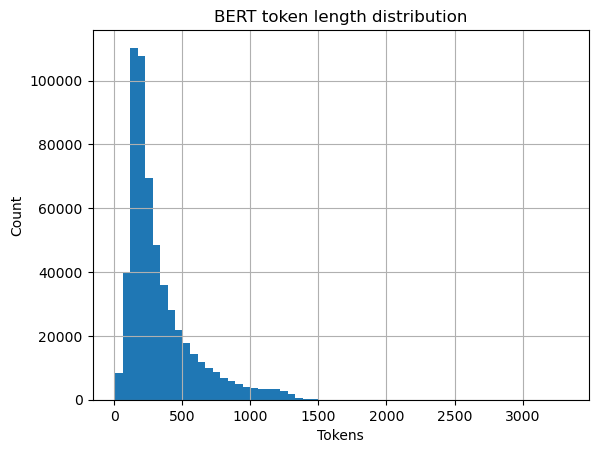

In [48]:
from transformers import BertTokenizerFast
import numpy as np
import matplotlib.pyplot as plt

tok_bert = BertTokenizerFast.from_pretrained("bert-base-uncased")

_texts = reviews["review_text"].astype(str).tolist()
token_lens = [len(tok_bert.encode(t, add_special_tokens=True)) for t in _texts]

reviews["bert_token_len"] = token_lens
print("Token length percentiles (50/75/90/95/99/max):",
      np.percentile(token_lens, [50, 75, 90, 95, 99]), int(np.max(token_lens)))

ax = reviews["bert_token_len"].hist(bins=60)
ax.set_title("BERT token length distribution")
ax.set_xlabel("Tokens")
ax.set_ylabel("Count")
plt.show()
